# FINM 25000 Midterm: Hung Le

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels as sm
from functools import partial
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
pd.options.display.float_format = '{:.4f}'.format
get_data = partial(
    pd.read_excel, "multi_asset_etf_data.xlsx", index_col=0, parse_dates=[0]
)

In [110]:
def calc_return_metrics(data, as_df=True, adj = 12):
    """
    Calculate return metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False (return a dict).
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    # summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
    #     data[data < 0].std() * np.sqrt(adj)
    # )
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=True, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False.
        adj (int, optional): Annualizatin. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Bottom"] = drawdowns.idxmin()
    summary["Peak"] = previous_peaks.idxmax()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_performance_metrics(data, adj = 12, var=0.05):
    """
    Aggregating function for calculating performance metrics. Returns both
    risk and performance metrics.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        adj (int, optional): Annualization. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        DataFrame: DataFrame of performance metrics.
    """
    summary = {
        **calc_return_metrics(data=data, as_df = False, adj=adj),
        **calc_risk_metrics(data=data, as_df = False, var=var),
    }
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)

def plot_correlation_matrix(corrs, ax=None):
    if ax:
        sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
            ax=ax,
        )
    # Correlation helper function.
    else:
        ax = sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
        )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    return ax


def print_max_min_correlation(corrs):
    # Correlation helper function. Prints the min/max/absolute value
    # for the correlation matrix.
    corr_series = corrs.unstack()
    corr_series = corr_series[corr_series != 1]

    max_corr = corr_series.abs().agg(["idxmax", "max"]).T
    min_corr = corr_series.abs().agg(["idxmin", "min"]).T
    min_corr_raw = corr_series.agg(["idxmin", "min"]).T
    max_corr, max_corr_val = max_corr["idxmax"], max_corr["max"]
    min_corr, min_corr_val = min_corr["idxmin"], min_corr["min"]
    min_corr_raw, min_corr_raw_val = min_corr_raw["idxmin"], min_corr_raw["min"]

    print(
        f"Max Corr (by absolute value): {max_corr[0]} and {max_corr[1]} with a correlation of {max_corr_val:.2f}"
    )
    print(
        f"Min Corr (by absolute value): {min_corr[0]} and {min_corr[1]} with a correlation of {min_corr_val:.2f}"
    )
    print(
        f"Min Corr (raw): {min_corr_raw[0]} and {min_corr_raw[1]} with a correlation of {min_corr_raw_val:.2f}"
    )

In [111]:
excess_rets = get_data('excess returns')
excess_rets.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0185
2009-05-31,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0204
2009-06-30,0.0046,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0448,-0.0040,-0.0013,0.0014
2009-07-31,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0009
2009-08-31,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0080


# Question 1.

## 1a

In [115]:
return_metrics = calc_return_metrics(excess_rets)[['Annualized Return', 'Annualized Volatility', 'Annualized Sharpe Ratio']]
display(return_metrics)

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
BWX,-0.0045,0.0854,-0.0531
DBC,0.0219,0.1755,0.1247
EEM,0.0650,0.1942,0.3345
EFA,0.0838,0.1648,0.5085
HYG,0.0629,0.0883,0.7125
IEF,0.0112,0.0643,0.1750
IYR,0.1227,0.1898,0.6467
PSP,0.1344,0.2270,0.5920
QAI,0.0194,0.0509,0.3803
SPY,0.1451,0.1479,0.9814


## 1b

In [116]:
return_metrics.sort_values('Annualized Sharpe Ratio')

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
BWX,-0.0045,0.0854,-0.0531
DBC,0.0219,0.1755,0.1247
IEF,0.0112,0.0643,0.1750
EEM,0.0650,0.1942,0.3345
QAI,0.0194,0.0509,0.3803
TIP,0.0202,0.0518,0.3910
EFA,0.0838,0.1648,0.5085
PSP,0.1344,0.2270,0.5920
IYR,0.1227,0.1898,0.6467
HYG,0.0629,0.0883,0.7125


BWX has the worst Sharpe, SPY has the best Sharpe

In [52]:
calc_risk_metrics(commodities, var = 0.01)[['VaR (0.01)', 'CVaR (0.01)', 'Max Drawdown']]

,VaR (0.01),CVaR (0.01),Max Drawdown
NG1,-0.3590,-0.3875,-0.9015
KC1,-0.1781,-0.2153,-0.7044
CC1,-0.1981,-0.2314,-0.5115
LB1,-0.2393,-0.2952,-0.7117
CT1,-0.2069,-0.2632,-0.7640
SB1,-0.2015,-0.2632,-0.7109
LC1,-0.1272,-0.1662,-0.4947
W1,-0.1922,-0.2208,-0.6695
S1,-0.2141,-0.2539,-0.5484
C1,-0.1961,-0.2287,-0.6339


## 1.3.

If it has low correlation with other assets 

## 1.4.

## 1.5.

In [104]:
def unitarget_regression(y, X,  multi_X = True, adj = 12):
    """
        Regress y against univariate/multivariate X
        y: pd.Series
        X: pd.DataFrame
        multi_X: Boolean
    """
    summary = {}
    reg = LinearRegression()
    reg.fit(X, y)
    summary['Annualized Alpha'] = reg.intercept_ * adj
    summary['Rsquared'] = reg.score(X, y)
    for i, x in enumerate(X.columns):
        summary[f'Beta {x}'] = reg.coef_[i]
    eps = y - reg.predict(X)
    summary['Annualized Information Ratio'] = reg.intercept_/eps.std() * np.sqrt(adj)
    summary['Annualized Tracking Error'] = eps.std() * np.sqrt(adj)
    if not multi_X:
        name_x = X.columns[0]
        summary['Annualized Treynor Ratio'] = y.mean()/summary[f'Beta {name_x}'] * adj
    return pd.DataFrame(summary, index = [y.name])

def multitarget_regression(y, X, multi_X = True, adj = 12):
    """
        y: pd.DataFrame
        X: pd.DataFrame
        multi_X: Boolean
    """
    return pd.concat([unitarget_regression(y[col], X, multi_X, adj) for col in y.columns], axis = 0)

def regression(y, X, multi_y = False, multi_X = False, adj = 12):
    """
        multi_y: Boolean
        multi_X: Boolean
    """
    if multi_y:
        return multitarget_regression(y, X, multi_X, adj)
    return unitarget_regression(y, X, multi_X, adj)

In [105]:
regression(commodities['SB1'], commodities[['C1']])

,Annualized Alpha,Rsquared,Beta C1,Annualized Information Ratio,Annualized Tracking Error,Annualized Treynor Ratio
SB1,0.0804,0.0120,0.1274,0.2333,0.3446,0.7172


## 1.6.

## 1.7.

## 1.8.

## 1.9.

## 1.10.

The hedge ratio would be 0.1274 Coffee to 1 C1, meaning for every $100 long in C1, short $12.74 in

# Question 2.

In [55]:
def calc_mv_portfolio(df, target = None):
    """

    """
    mean_rets = df.mean()
    cov_matrix = df.cov()
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(mean_rets.shape)
    w_tan = (inv_cov @ mean_rets) / (ones.T @ (inv_cov @ mean_rets))
    if target is None:
        return pd.DataFrame({"Tangency Portfolio": w_tan}, index=df.columns)

    return pd.DataFrame({
        "Tangency Portfolio": w_tan,
        "Target Portfolio": w_tan * target/(mean_rets @ w_tan)
    }, index=df.columns)


## 2.1.

## 2.2.

In [56]:
weights = calc_mv_portfolio(commodities, 0.0075)
display(weights)

,Tangency Portfolio,Target Portfolio
NG1,0.0574,0.0591
KC1,-0.0728,-0.0749
CC1,0.0745,0.0766
LB1,0.0866,0.0891
CT1,-0.0095,-0.0098
SB1,0.0636,0.0654
LC1,0.1289,0.1326
W1,-0.0104,-0.0107
S1,0.0273,0.0281
C1,0.0848,0.0872


## 2.3.

In [57]:
weights['Sharpe'] = calc_return_metrics(commodities)['Annualized Sharpe Ratio']
display(weights)

,Tangency Portfolio,Target Portfolio,Sharpe
NG1,0.0574,0.0591,0.2676
KC1,-0.0728,-0.0749,0.1401
CC1,0.0745,0.0766,0.2612
LB1,0.0866,0.0891,0.3267
CT1,-0.0095,-0.0098,0.1864
SB1,0.0636,0.0654,0.2635
LC1,0.1289,0.1326,0.1576
W1,-0.0104,-0.0107,0.2441
S1,0.0273,0.0281,0.2688
C1,0.0848,0.0872,0.2882


## 2.4.

In [58]:
calc_return_metrics(commodities @ weights['Target Portfolio'].to_frame('Target Portfolio'))

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Target Portfolio,0.0900,0.1196,0.7524


## 2.5.

## 2.6.

# Question 3.

## 3.1.

In [106]:
regression(commodities, factors[['MKT', 'UMD']], multi_y=True, multi_X = True)

,Annualized Alpha,Rsquared,Beta MKT,Beta UMD,Annualized Information Ratio,Annualized Tracking Error
NG1,0.1120,0.0173,0.3541,0.3812,0.2099,0.5334
KC1,0.0232,0.0259,0.3151,-0.0275,0.0733,0.3167
CC1,0.0708,0.0120,0.2073,-0.0358,0.2194,0.3226
LB1,0.0645,0.1368,0.9421,-0.0048,0.1732,0.3723
CT1,0.0249,0.0990,0.5042,-0.1786,0.0855,0.2915
SB1,0.0931,0.0327,0.0580,-0.3192,0.2731,0.3410
LC1,0.0154,0.0200,0.1831,0.0661,0.0830,0.1857
W1,0.0545,0.0213,0.2989,0.0224,0.1769,0.3082
S1,0.0425,0.0529,0.3995,0.0273,0.1649,0.2579
C1,0.0609,0.0282,0.3404,0.0620,0.2068,0.2943


## 3.2.

## 3.3.

## 3.4.

## 3.5.

## 3.6.

# Question 4.

## 4.1.

In [107]:
def lagged(y, X, delta_shift = 1):
    """
        y: pd.Series
        X: pd.DataFrame
    """
    X = X.shift(delta_shift).dropna()
    y = y.loc[X.index]
    reg = LinearRegression()
    reg.fit(X, y)
    stats= {}
    stats['Rsquared'] = reg.score(X, y)
    stats['Alpha'] = reg.intercept_,
    for i, x in enumerate(X.columns):
        stats[f'Beta {x}'] = reg.coef_[i]
    yhat = reg.predict(X)
    w = 0.2 + 0.8 * yhat
    X_name = ', '.join(X.columns)
    strategy_rets = (w * y).rename(X_name)
    return {
        'stats': pd.DataFrame(stats, index = [X_name]),
        'strategy_rets': pd.DataFrame(strategy_rets),
        'yhat': yhat
    }

In [108]:
lagged_results = lagged(forecasting['GLD'], forecasting[['Tbill rate', 'Tbill change']])
display(lagged_results['stats'])

,Rsquared,Alpha,Beta Tbill rate,Beta Tbill change
"Tbill rate, Tbill change",0.0001,0.0010,0.0003,0.0005


## 4.2.

In [96]:
trading_rets = lagged_results['strategy_rets']
display(trading_rets.head())
display(trading_rets.tail())
forecasting['GLD Trading'] = trading_rets

,"Tbill rate, Tbill change"
Date,
2009-04-26,0.0106
2009-05-03,-0.0062
2009-05-10,0.0070
2009-05-17,0.0035
2009-05-24,0.0057


,"Tbill rate, Tbill change"
Date,
2022-11-06,0.0044
2022-11-13,0.0104
2022-11-20,-0.0022
2022-11-27,0.0005
2022-12-04,-0.0006


## 4.3.

In [102]:
rets = forecasting[['GLD', 'GLD Trading']]
calc_performance_metrics(rets, adj = 12)[['Annualized Return','Annualized Volatility']].T

,GLD,GLD Trading
Annualized Return,0.0580,0.0118
Annualized Volatility,0.1523,0.0306


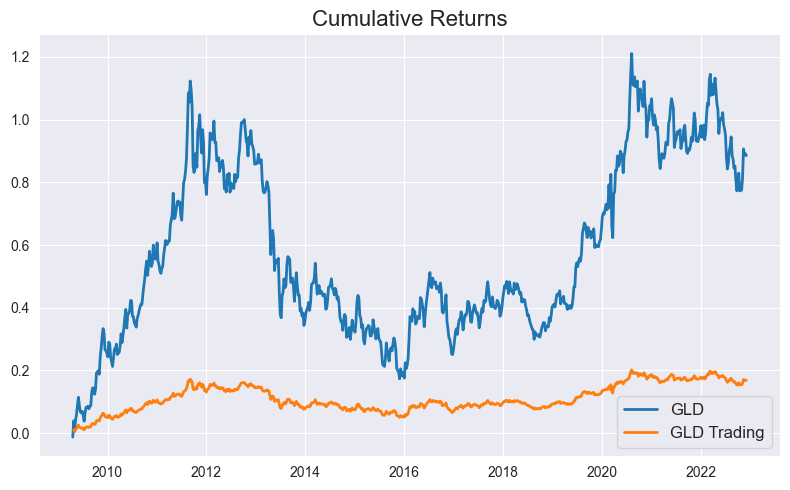

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))
cum_rets = (rets + 1).cumprod() - 1
ax.plot(cum_rets, lw=2)
ax.set_title("Cumulative Returns", fontsize=16)
ax.legend(cum_rets.columns, fontsize=12)
fig.tight_layout()

## 4.4.

## 4.5.

## 4.6.